<h1>Проект: Создание прогностической модели для выявления диабета</h1>

Цель: обучить модель для выявления диабета с использованием метрки f1 Macro для оценки качества модели.

# Импорт библиотек


In [1]:
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 8.8 MB/s eta 0:00:00


In [2]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.6 MB/s eta 0:00:00


In [3]:
!pip install lightgbm -q

In [4]:
import re
import time
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import phik
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
    f_classif,
    mutual_info_classif
)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

from scipy.stats import uniform
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
import ipywidgets as widgets
from IPython.display import display

pd.set_option('display.max_columns', None)

# Константы

In [5]:
RANDOM_STATE = 654321
TEST_SIZE = 0.3

# Загрузка данных

In [6]:
url = f"https://drive.google.com/uc?id=1Q9pZPt77ejFCc96jyxJBUqLVNCqjg7S-"
gdown.download(url, 'Копия diabetes_ds.xlsx', quiet=False)
df = pd.read_excel('Копия diabetes_ds.xlsx')

Downloading...
From: https://drive.google.com/uc?id=1Q9pZPt77ejFCc96jyxJBUqLVNCqjg7S-
To: /content/Копия diabetes_ds.xlsx
100%|██████████| 319k/319k [00:00<00:00, 42.8MB/s]


# Предобработка и исследовательский анализ данных

## Первичный осмотр данных

Общая информация о датасете

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Columns: 108 entries, Номер to Сахарный диабет (ЕСТЬ\НЕТ)
dtypes: float64(101), object(7)
memory usage: 408.5+ KB


In [8]:
df.head()

,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,Лейкоциты,Лимфоциты%,"ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)",Тромбоциты,СОЭ,Холестерин,ЛПНП,ЛПВП,Индекс атерогенности 2 (формула excel),Глюкоза,Гликированный гемоглобин,СРБ,Ферритин,Прокальцитонин,Альбумин,Лактат,ЛДГ,АЛТ,АСТ,Общий билирубин,Натрийуретический пептид,Мочевина,"Креатинин, мкмоль/л",СКФ CKD-EPI (расчет по общей формуле),Натрий,Калий,АЧТВ,МНО,Фибриноген,D-димер,Фавипиравир,Молнупиравир,Гидрохлортиазид,Фуросемид,Торасемид,Спиронолактон,Валсартан,Телмисартан,Лозартан,Кандесартан,Изосорбида динитрат,Периндоприл,Рамиприл,Эналаприл,Лизиноприл,Бисопролол,Карведилол,Атенолол,Верапамил,Дилтиазем,Леркамен,Амлодипин,Дигоксин,Ивабрадин,Гиполипидемические препараты (статины),"Антикоагулянты, препарат","Антикоагулянты, препарат 2","Антиагреганты, препарат 1","Антиагреганты, препарат 2",Триметазидин,Метформин,Дапаглифлозин,СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ,ОЖИРЕНИЕ (ЕСТЬ\НЕТ),BPB голеней,BPB голеней (ЕСТЬ/НЕТ),Тромбоэмболический синдром,ВПС,НЕАЖБП,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий),Блокада НП Гисса,Блокада НП Гисса (комментарий),Удлинение интервала QT,AV- блокада,ХБП (исходн),ХБП (расчет по СКФ),ХБП (ЕСТЬ\НЕТ),Мерцательная аритмия,Мерцательная аритмия (ЕСТЬ\НЕТ),Аблация,АКШ,БА,БА (ЕСТЬ/НЕТ),ХОБЛ,ХОБЛ (ЕСТЬ\НЕТ),ИБС. Стенокардия,ИБС. Стенокардия (ЕСТЬ\НЕТ),ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет (ЕСТЬ\НЕТ)
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,6.5,0.19,NaN,NaN,NaN,NaN,NaN,24.0,21.0,NaN,197.7,NaN,79.80,65.460393,NaN,5.76,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,6.1,NaN,NaN,NaN,46.0,NaN,NaN,12.0,14.0,NaN,2358.0,10.10,107.28,67.223532,140.4,4.38,38.2,2.34,3.71,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,2.0,1.0,1,1.0,1.0,0.0,0.0,1.0,умеренная гипертрофия,1,полная блокада,0.0,0,с3б,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5,20.7,18.1,NaN,NaN,106.20,61.677030,140.6,4.30,33.7,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,1.0,NaN,0.0,0.0,0.0,2.0,1.0,1,1.0,0.0,0.0,0.0,1.0,NaN,1-2,NaN,0.0,1,с3,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35,1.0
3,166.0,1.0,67.0,1.0,189.0,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,NaN,NaN,NaN,NaN,4.98,NaN,20.35,NaN,NaN,43.6,NaN,327.0,17.9,23.8,23.3,454.6,10.78,91.20,74.666361,140.6,4.00,26.3,1.09,3.68,NaN,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,NaN,0.0,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,NaN,1,NaN,0.0,1,0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0,1.0
4,439.0,1.0,60.0,1.0,178.0,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.7,3.20,81.70,89.585462,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,NaN,1.0,NaN,0.0,0.0,1.0,2.0,1.0,0,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2

Переведем названия столбцов к нижнему регистру и все символы заменим на "_".

In [9]:
def clean_columns(df):
    df.columns = [
        re.sub(r'_+', '_',
            re.sub(r'[\\/:*?"<>|{}\[\],.\s-]+', '_', col)
        ).strip('_').lower()
        for col in df.columns
    ]
    return df
df = clean_columns(df)
df.head()

,номер,перенес_не_перенес_кви,возраст,пол,рост_см,вес_кг,имт_2_(формула_excel),эритроциты,гемоглобин,цветовой_показатель,лейкоциты,лимфоциты%,лимфоциты_абс_(расчет_по_формуле),тромбоциты,соэ,холестерин,лпнп,лпвп,индекс_атерогенности_2_(формула_excel),глюкоза,гликированный_гемоглобин,срб,ферритин,прокальцитонин,альбумин,лактат,лдг,алт,аст,общий_билирубин,натрийуретический_пептид,мочевина,креатинин_мкмоль_л,скф_ckd_epi_(расчет_по_общей_формуле),натрий,калий,ачтв,мно,фибриноген,d_димер,фавипиравир,молнупиравир,гидрохлортиазид,фуросемид,торасемид,спиронолактон,валсартан,телмисартан,лозартан,кандесартан,изосорбида_динитрат,периндоприл,рамиприл,эналаприл,лизиноприл,бисопролол,карведилол,атенолол,верапамил,дилтиазем,леркамен,амлодипин,дигоксин,ивабрадин,гиполипидемические_препараты_(статины),антикоагулянты_препарат,антикоагулянты_препарат_2,антиагреганты_препарат_1,антиагреганты_препарат_2,триметазидин,метформин,дапаглифлозин,степени_ожирения_по_имт,ожирение_(есть_нет),bpb_голеней,bpb_голеней_(есть_нет),тромбоэмболический_синдром,впс,неажбп,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг_(комментарий),блокада_нп_гисса,блокада_нп_гисса_(комментарий),удлинение_интервала_qt,av_блокада,хбп_(исходн),хбп_(расчет_по_скф),хбп_(есть_нет),мерцательная_аритмия,мерцательная_аритмия_(есть_нет),аблация,акш,ба,ба_(есть_нет),хобл,хобл_(есть_нет),ибс_стенокардия,ибс_стенокардия_(есть_нет),ибс_пикс,ибс_пикс_(есть_нет),аг_стадия,аг_(есть_нет),аг_степень,аг_риск,хсн_стадии,хсн_фк,хсн_по_фракции_выброса_%,сахарный_диабет_(есть_нет)
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,6.5,0.19,NaN,NaN,NaN,NaN,NaN,24.0,21.0,NaN,197.7,NaN,79.80,65.460393,NaN,5.76,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,6.1,NaN,NaN,NaN,46.0,NaN,NaN,12.0,14.0,NaN,2358.0,10.10,107.28,67.223532,140.4,4.38,38.2,2.34,3.71,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,2.0,1.0,1,1.0,1.0,0.0,0.0,1.0,умеренная гипертрофия,1,полная блокада,0.0,0,с3б,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5,20.7,18.1,NaN,NaN,106.20,61.677030,140.6,4.30,33.7,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,1.0,NaN,0.0,0.0,0.0,2.0,1.0,1,1.0,0.0,0.0,0.0,1.0,NaN,1-2,NaN,0.0,1,с3,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35,1.0
3,166.0,1.0,67.0,1.0,189.0,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,NaN,NaN,NaN,NaN,4.98,NaN,20.35,NaN,NaN,43.6,NaN,327.0,17.9,23.8,23.3,454.6,10.78,91.20,74.666361,140.6,4.00,26.3,1.09,3.68,NaN,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,NaN,0.0,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,NaN,1,NaN,0.0,1,0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0,1.0
4,439.0,1.0,60.0,1.0,178.0,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.7,3.20,81.70,89.585462,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,NaN,1.0,NaN,0.0,0.0,1.0,2.0,1.0,0,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,0,1.0


In [10]:
df = df.rename(columns={
    'bpb_голеней': 'врв_голеней',
    'bpb_голеней_(есть_нет)': 'врв_голеней_(есть_нет)'
})

Проверим количество пропусков в столбцах.

In [11]:
na_counts = pd.DataFrame(df.isna().sum(), columns=['Количество пропусков'])
na_counts_sorted = na_counts.sort_values(by='Количество пропусков',ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(na_counts_sorted)

                                                    Количество пропусков
прокальцитонин                                                       482
лактат                                                               474
антикоагулянты_препарат_2                                            472
антиагреганты_препарат_2                                             467
гипертрофия_миокарда_левого_желудочка_по_экг_ил...                   458
ферритин                                                             454
блокада_нп_гисса_(комментарий)                                       443
лдг                                                                  443
d_димер                                                              423
фибриноген                                                           381
срб                                                                  359
ачтв                                                                 338
альбумин                                           

Удалим строки с пропусками в целевом признаке, т.к. такие строки нельзя использовать для обучения или оценки модели.
   
Также удалим строки с пропусками в признаке "Глюкоза", так как содержание глюкозы в крови - один из важнейших показателей при диагностике диабета, считаем, что заполнять пропуски искусственными значениями некорректно.

In [12]:
df.dropna(subset=['сахарный_диабет_(есть_нет)', 'глюкоза'], inplace=True)

Проверим количество пропусков по строкам.

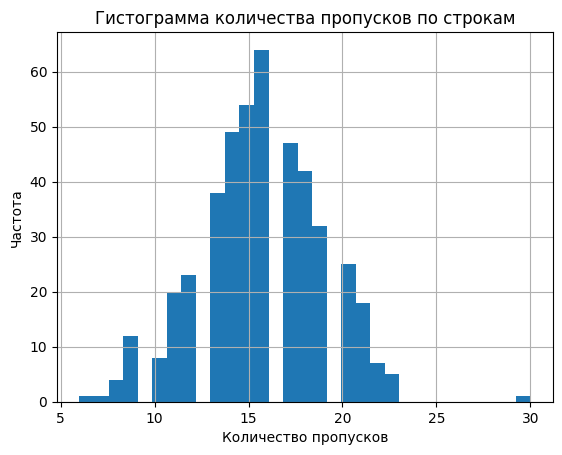

In [13]:
df.isnull().sum(axis=1).hist(bins=31)
plt.xlabel('Количество пропусков')
plt.ylabel('Частота')
plt.title('Гистограмма количества пропусков по строкам')
plt.show()

В датасете имеется одна строка с большим количеством пропусков, которая выпадает из общей картины. Её следует удалить.

In [14]:
df.drop(index=df[df.isnull().sum(axis=1) == 30].index, inplace=True)

Удалим столбцы с большим количеством пропусков (больше 117 в столбце, что составляет 24% от общего числа значений в столбце).

In [15]:
na_counts_ = df.isna().sum()
cols_to_drop = na_counts[na_counts_> 117].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)
print('Были удалены признаки:')
for s in cols_to_drop:
    print('   '+s)

Были удалены признаки:
   гликированный_гемоглобин
   срб
   ферритин
   прокальцитонин
   альбумин
   лактат
   лдг
   общий_билирубин
   натрий
   калий
   ачтв
   мно
   фибриноген
   d_димер
   антикоагулянты_препарат_2
   антиагреганты_препарат_1
   антиагреганты_препарат_2
   гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг_(комментарий)
   блокада_нп_гисса_(комментарий)


Проверим число дубликатов

In [16]:
print(f'Количество дубликатов = {df.duplicated().sum()}')


Количество дубликатов = 0


Сделаем столбец `Номер` индексом таблицы.

In [17]:
df.set_index('номер', inplace=True)
df.index = df.index.astype(int)

Проверим размерность датасета после удалений

In [18]:
df.shape

(450, 88)

In [19]:
(484 - df.shape[0]) / 484 * 100

7.024793388429752

Исходный датасет содержал **484 строки и 108 столбцов**.
Удаленые строки составили **7%** от изначального датасета.

In [20]:
df.head()

,перенес_не_перенес_кви,возраст,пол,рост_см,вес_кг,имт_2_(формула_excel),эритроциты,гемоглобин,цветовой_показатель,лейкоциты,лимфоциты%,лимфоциты_абс_(расчет_по_формуле),тромбоциты,соэ,холестерин,лпнп,лпвп,индекс_атерогенности_2_(формула_excel),глюкоза,алт,аст,натрийуретический_пептид,мочевина,креатинин_мкмоль_л,скф_ckd_epi_(расчет_по_общей_формуле),фавипиравир,молнупиравир,гидрохлортиазид,фуросемид,торасемид,спиронолактон,валсартан,телмисартан,лозартан,кандесартан,изосорбида_динитрат,периндоприл,рамиприл,эналаприл,лизиноприл,бисопролол,карведилол,атенолол,верапамил,дилтиазем,леркамен,амлодипин,дигоксин,ивабрадин,гиполипидемические_препараты_(статины),антикоагулянты_препарат,триметазидин,метформин,дапаглифлозин,степени_ожирения_по_имт,ожирение_(есть_нет),врв_голеней,врв_голеней_(есть_нет),тромбоэмболический_синдром,впс,неажбп,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг,блокада_нп_гисса,удлинение_интервала_qt,av_блокада,хбп_(исходн),хбп_(расчет_по_скф),хбп_(есть_нет),мерцательная_аритмия,мерцательная_аритмия_(есть_нет),аблация,акш,ба,ба_(есть_нет),хобл,хобл_(есть_нет),ибс_стенокардия,ибс_стенокардия_(есть_нет),ибс_пикс,ибс_пикс_(есть_нет),аг_стадия,аг_(есть_нет),аг_степень,аг_риск,хсн_стадии,хсн_фк,хсн_по_фракции_выброса_%,сахарный_диабет_(есть_нет)
номер,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
390,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,24.0,21.0,197.7,NaN,79.80,65.460393,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0,1.0
337,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,12.0,14.0,2358.0,10.10,107.28,67.223532,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1,1.0,1.0,0.0,0.0,1.0,1,0.0,0,с3б,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35,1.0
160,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,16.5,20.7,NaN,NaN,106.20,61.677030,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,1,1.0,0.0,0.0,0.0,1.0,1-2,0.0,1,с3,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35,1.0
166,1.0,67.0,1.0,189.0,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,NaN,NaN,NaN,NaN,4.98,17.9,23.8,454.6,10.78,91.20,74.666361,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0,1.0
439,1.0,60.0,1.0,178.0,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,NaN,NaN,280.7,3.20,81.70,89.585462,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,0,1.0


Проверим распределение классов после удалений

In [21]:
round(df['сахарный_диабет_(есть_нет)'].value_counts(normalize=True) * 100)

,proportion
сахарный_диабет_(есть_нет),
1.0,53.0
0.0,47.0


Имеется незначительный дисбаланс классов.

Разделим данные на **дискретные** и **непрерывные**

In [22]:
discrete_cols = df.select_dtypes(include=['object']).columns.tolist()
float_cols = df.select_dtypes(include=['float64']).columns.tolist()

for col in float_cols:
    nunique = df[col].nunique(dropna=True)
    if nunique <= 15:
        discrete_cols.append(col)

continuous_cols = [col for col in float_cols if col not in discrete_cols]

In [23]:
print(f"Категориальные и дискретные признаки ({len(discrete_cols)}):")
for col in discrete_cols:
    print(" -", col)

print(f"Непрерывные признаки ({len(continuous_cols)}):")
for col in continuous_cols:
    print(" -", col)

Категориальные и дискретные признаки (66):
 - врв_голеней
 - блокада_нп_гисса
 - av_блокада
 - хбп_(исходн)
 - хсн_по_фракции_выброса_%
 - перенес_не_перенес_кви
 - пол
 - цветовой_показатель
 - фавипиравир
 - молнупиравир
 - гидрохлортиазид
 - фуросемид
 - торасемид
 - спиронолактон
 - валсартан
 - телмисартан
 - лозартан
 - кандесартан
 - изосорбида_динитрат
 - периндоприл
 - рамиприл
 - эналаприл
 - лизиноприл
 - бисопролол
 - карведилол
 - атенолол
 - верапамил
 - дилтиазем
 - леркамен
 - амлодипин
 - дигоксин
 - ивабрадин
 - гиполипидемические_препараты_(статины)
 - антикоагулянты_препарат
 - триметазидин
 - метформин
 - дапаглифлозин
 - степени_ожирения_по_имт
 - ожирение_(есть_нет)
 - врв_голеней_(есть_нет)
 - тромбоэмболический_синдром
 - впс
 - неажбп
 - гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг
 - удлинение_интервала_qt
 - хбп_(расчет_по_скф)
 - хбп_(есть_нет)
 - мерцательная_аритмия
 - мерцательная_аритмия_(есть_нет)
 - аблация
 - акш
 - ба
 - ба_(есть_нет)
 - 

Оценим распределение значений в непрерывных признаках и изучим на наличие аномалий.

In [24]:
# Функция для отображения гистограммы и boxplot по выбранному признаку
def plot_continuous_feature(column):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Гистограмма
    axes[0].hist(df[column].dropna(), bins=20, alpha=0.7)
    axes[0].set_title(f'Гистограмма: {column}')
    axes[0].set_ylabel('Частота')

    # Boxplot
    axes[1].boxplot(df[column].dropna(), vert=False)
    axes[1].set_title(f'Boxplot: {column}')
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

continuous_cols = list(set(continuous_cols) & set(continuous_cols))
# Выпадающий список со всеми непрерывными признаками
dropdown = widgets.Dropdown(
    options=continuous_cols,
    description='ВЫБЕРИТЕ ПРИЗНАК:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Привязка интерактива
widgets.interact(plot_continuous_feature, column=dropdown);

interactive(children=(Dropdown(description='ВЫБЕРИТЕ ПРИЗНАК:', layout=Layout(width='50%'), options=('скф_ckd_…

Пропуски в признаках с нормальным распределением можно заменить медианой.   
Пропуски со смещенным распределением (соэ, лпнп, лпвп, алт, аст, натрийуретический пептид, мочевина) лучше заполнить модой.   
В признаке имт 2 (формула_excel) обнаружено аномальное значение равное нулю.

In [25]:
df[df['имт_2_(формула_excel)'] < 10]

,перенес_не_перенес_кви,возраст,пол,рост_см,вес_кг,имт_2_(формула_excel),эритроциты,гемоглобин,цветовой_показатель,лейкоциты,лимфоциты%,лимфоциты_абс_(расчет_по_формуле),тромбоциты,соэ,холестерин,лпнп,лпвп,индекс_атерогенности_2_(формула_excel),глюкоза,алт,аст,натрийуретический_пептид,мочевина,креатинин_мкмоль_л,скф_ckd_epi_(расчет_по_общей_формуле),фавипиравир,молнупиравир,гидрохлортиазид,фуросемид,торасемид,спиронолактон,валсартан,телмисартан,лозартан,кандесартан,изосорбида_динитрат,периндоприл,рамиприл,эналаприл,лизиноприл,бисопролол,карведилол,атенолол,верапамил,дилтиазем,леркамен,амлодипин,дигоксин,ивабрадин,гиполипидемические_препараты_(статины),антикоагулянты_препарат,триметазидин,метформин,дапаглифлозин,степени_ожирения_по_имт,ожирение_(есть_нет),врв_голеней,врв_голеней_(есть_нет),тромбоэмболический_синдром,впс,неажбп,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг,блокада_нп_гисса,удлинение_интервала_qt,av_блокада,хбп_(исходн),хбп_(расчет_по_скф),хбп_(есть_нет),мерцательная_аритмия,мерцательная_аритмия_(есть_нет),аблация,акш,ба,ба_(есть_нет),хобл,хобл_(есть_нет),ибс_стенокардия,ибс_стенокардия_(есть_нет),ибс_пикс,ибс_пикс_(есть_нет),аг_стадия,аг_(есть_нет),аг_степень,аг_риск,хсн_стадии,хсн_фк,хсн_по_фракции_выброса_%,сахарный_диабет_(есть_нет)
номер,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
203,2.0,56.0,1.0,NaN,NaN,0.0,5.2,139.0,0.0,4.9,34.6,1.6954,200.0,3.0,4.36,2.53,1.46,1.986301,4.5,87.6,54.2,3670.0,6.4,91.4,80.451299,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,1.0,0.0,0.0,0.0,0.0,0,0.0,0,0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,4.0,2.0,2.0,30,0.0


In [26]:
df[continuous_cols].isna().sum()

,0
скф_ckd_epi_(расчет_по_общей_формуле),10
лпнп,33
натрийуретический_пептид,40
соэ,39
гемоглобин,0
мочевина,105
лимфоциты_абс_(расчет_по_формуле),2
вес_кг,1
алт,54
лимфоциты%,1


Нулевое значение в ИМТ связано с отсутствием значений роста и веса. После заполнения пропусков ИМТ можно пересчитать самостоятельно как вес(кг)/рост(м)^2.
Индекс атерогенности рассчитывается на основании значений холестерина и лпвп, данный показатель будет пересчитан после заполнения пропусков в холестерине и лпвп.

Изучим категориальные признаки. Выбрать нужный признак можно в выпадающем меню над графиком

In [27]:
df_copy = df.copy()
# Функция для построения графика по одному признаку
def plot_single_feature(column):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=column, data=df_copy)
    plt.title(column)
    plt.ylabel("Частота")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

discrete_cols = list(set(discrete_cols) & set(df.columns))
# Виджет dropdown со всеми категориальными признаками
dropdown = widgets.Dropdown(
    options=discrete_cols,
    description='ВЫБЕРИТЕ ПРИЗНАК:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Привязка интерактива
widgets.interact(plot_single_feature, column=dropdown);

interactive(children=(Dropdown(description='ВЫБЕРИТЕ ПРИЗНАК:', layout=Layout(width='50%'), options=('хсн_по_ф…

Большая часть признаков связана с приемом лекарственных препаратов или наличием заболевания. Очевидно, что пропуски в данных признаках можно расценивать как "0", т.е. человек не принимает препарат, либо у него отсутствует заболевание.

**Выводы**

На этапе первичного анализа данных:

- Были приведены в порядок названия столбцов и удалены явные дубликаты и строки с критически важными пропусками.
- Удалены признаки с большим количеством пропущенных значений.
- Общие потери составили около **7% строк** от исходного датасета.
- Проведено разделение признаков на **категориальные**/**дискретные** и **непрерывные**.
- Проведена визуализация распределений непрерывных и категориальных признаков, выявлены потенциальные аномалии и закономерности.
- Определена стратегия заполнения пропусков:
  - медианой — для признаков с нормальным распределением,
  - модой — для признаков с асимметричным распределением,
  - пересчётом — для производных признаков (например, ИМТ и индекс атерогенности).
- Пропуски в категориальных признаках, связанных с приёмом лекарств и заболеваниями, будут интерпретироваться как **отсутствие признака** (т.е. "0").


## Обработка пропусков

Заменим пропуски в непрерывных столбцах модой или медианой в зависимоти от типа распределения.

In [28]:
print(f"Непрерывные признаки ({len(continuous_cols)}):")
for col in continuous_cols:
    print(" -", col)

Непрерывные признаки (22):
 - скф_ckd_epi_(расчет_по_общей_формуле)
 - лпнп
 - натрийуретический_пептид
 - соэ
 - гемоглобин
 - мочевина
 - лимфоциты_абс_(расчет_по_формуле)
 - вес_кг
 - алт
 - лимфоциты%
 - имт_2_(формула_excel)
 - индекс_атерогенности_2_(формула_excel)
 - лейкоциты
 - лпвп
 - тромбоциты
 - возраст
 - креатинин_мкмоль_л
 - эритроциты
 - глюкоза
 - рост_см
 - холестерин
 - аст


Признаки с асимметричным распределением заполняем модой.

In [29]:
cols_mode = ['соэ', 'лпнп', 'лпвп', 'алт', 'аст', 'натрийуретический_пептид', 'мочевина']
for col in cols_mode:
    df[col] = df[col].fillna(df[col].mode()[0])

Признаки с нормальным распределением заполняем медианой.

In [30]:
cols_median = [col for col in continuous_cols if col not in cols_mode]
for col in cols_median:
    df[col] = df[col].fillna(df[col].median())

Проверка корректности замены пропусков в столбцах с непрерывными признаками.

In [31]:
sum(df[continuous_cols].isna().sum())

0

Проверим, в каких дискретных признаках содержатся пропуски.

In [32]:
discrete_unique_values = {col: df[col].unique() for col in discrete_cols}
discrete_unique_values

{'хсн_по_фракции_выброса_%': array([0, 35, 40, 42, 34, 31, 33, 23, 29, 41, 38, '24-25', 30, 27, 32, 36,
        50, 45, '25.9', 28, 39, 58, 26, 37, 51, '22-25', 59, 46, 25, 48,
        '32-36', 43, 49, 20, '20-25', '39-40', '15-20', 18, 24, '34-35',
        '30-31', '28-30', 47, 22, 61, 21, 66, '42-43', '36-38', '30-32',
        'с2', '28.9', '43.4', '32-33', '30-35', 44, '34-36', '40-41', 17,
        '33-48', '33-35', '46-48', '38-40', '35-37', '21-25', '24-26',
        '33-52', '37-47', '23-25', '55-56', '20-32', '18-20', 57],
       dtype=object),
 'мерцательная_аритмия': array([ 0.,  1.,  2., nan]),
 'врв_голеней': array([0, 1, 4, 2, 3, '2-3'], dtype=object),
 'дилтиазем': array([0., 1.]),
 'ибс_пикс': array([1., 0.]),
 'хбп_(исходн)': array([0, 'с3б', 'с3', 'с2', 'с3а', '2а', 'с4', 'с1', 'с3а-с3б', 'с2-с3',
        '2са1', 'с1 а3'], dtype=object),
 'триметазидин': array([ 0.,  1., nan]),
 'ожирение_(есть_нет)': array([ 1.,  0., nan]),
 'акш': array([0., 1.]),
 'сахарный_диабет_(ес

Признак ХБП (расчет по СКФ) содержит значения от 1 до 5 и пропуски. Необходимо более детально изучить данный признак перед заполнением пропусков.  
Пропуски в остальных признаках можно заполнить нулями.

In [33]:
df[df['хбп_(расчет_по_скф)'].isnull()]

,перенес_не_перенес_кви,возраст,пол,рост_см,вес_кг,имт_2_(формула_excel),эритроциты,гемоглобин,цветовой_показатель,лейкоциты,лимфоциты%,лимфоциты_абс_(расчет_по_формуле),тромбоциты,соэ,холестерин,лпнп,лпвп,индекс_атерогенности_2_(формула_excel),глюкоза,алт,аст,натрийуретический_пептид,мочевина,креатинин_мкмоль_л,скф_ckd_epi_(расчет_по_общей_формуле),фавипиравир,молнупиравир,гидрохлортиазид,фуросемид,торасемид,спиронолактон,валсартан,телмисартан,лозартан,кандесартан,изосорбида_динитрат,периндоприл,рамиприл,эналаприл,лизиноприл,бисопролол,карведилол,атенолол,верапамил,дилтиазем,леркамен,амлодипин,дигоксин,ивабрадин,гиполипидемические_препараты_(статины),антикоагулянты_препарат,триметазидин,метформин,дапаглифлозин,степени_ожирения_по_имт,ожирение_(есть_нет),врв_голеней,врв_голеней_(есть_нет),тромбоэмболический_синдром,впс,неажбп,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг,блокада_нп_гисса,удлинение_интервала_qt,av_блокада,хбп_(исходн),хбп_(расчет_по_скф),хбп_(есть_нет),мерцательная_аритмия,мерцательная_аритмия_(есть_нет),аблация,акш,ба,ба_(есть_нет),хобл,хобл_(есть_нет),ибс_стенокардия,ибс_стенокардия_(есть_нет),ибс_пикс,ибс_пикс_(есть_нет),аг_стадия,аг_(есть_нет),аг_степень,аг_риск,хсн_стадии,хсн_фк,хсн_по_фракции_выброса_%,сахарный_диабет_(есть_нет)
номер,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
333,1.0,69.0,2.0,152.0,77.0,33.327562,4.29,110.0,0.0,9.38,19.2,1.80096,250.0,78.0,3.92,2.00,0.93,2.526174,5.26,40.38,41.72,874.33,5.20,98.0,66.653303,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0,0.0,0,с3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,4.0,2.0,2.0,0,1.0
151,1.0,63.0,1.0,178.0,89.0,28.089888,5.47,139.0,0.0,7.00,22.3,1.56100,223.0,5.0,3.55,1.71,0.93,2.817204,16.20,11.90,16.10,2092.00,5.20,98.0,66.653303,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,4.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,0,1.0
61,1.0,68.0,2.0,165.0,75.0,27.548209,4.05,104.0,0.0,8.50,16.5,1.40250,325.0,29.0,3.92,2.00,0.89,2.526174,10.20,35.10,31.00,136.00,31.30,98.0,66.653303,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,4.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,с4,NaN,NaN,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,4.0,3.0,3.0,20,1.0
266,1.0,62.0,1.0,182.0,85.0,25.661152,5.74,171.0,0.0,7.30,23.0,1.67900,157.0,2.0,4.08,1.55,0.90,3.533333,7.26,20.00,19.00,2336.00,7.41,98.0,66.653303,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,4.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,2-3,0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,4.0,2.0,3.0,23,0.0
308,1.0,41.0,1.0,182.0,184.0,55.548847,5.12,162.0,0.0,8.57,25.8,2.21106,355.0,25.0,4.58,3.05,0.93,2.526174,6.88,41.00,34.00,254.00,5.20,98.0,66.653303,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,3.0,1.0,1,1.0,0.0,0.0,0.0,1.0,0,0.0,0,0,NaN,NaN,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,4.0,3.0,4.0,25,1.0
41,2.0,64.0,1.0,170.0,104.0,35.986159,5.60,150.0,0.0,8.20,24.7,2.02540,91.0,3.0,3.46,1.87,0.76,3.552632,7.30,14.60,17.30,136.00,5.20,98.0,66.653303,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1,1.0,0.0,0.0,0.0,0.0,1,0.0,0,с2,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,4.0,2.0,2.0,34,1.0
126,2.0,65.0,1.0,175.0,92.0,30.040816,4.88,133.0,0.0,5.80,22.6,1.31080,154.0,2.0,2.55,1.80,0.73,2.493151,7.10,9.10,23.50,136.00,5.20,98.0,66.653303,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0

In [34]:
hbp_range = df.groupby('хбп_(расчет_по_скф)',observed=False)['скф_ckd_epi_(расчет_по_общей_формуле)'].agg(
    lambda x: f"{x.min()} - {x.max()}"
)

ranges_df = hbp_range.reset_index()
ranges_df[['min_val', 'max_val']] = ranges_df['скф_ckd_epi_(расчет_по_общей_формуле)'].str.split(' - ', expand=True)
ranges_df['min_val'] = ranges_df['min_val'].astype(float)
ranges_df['max_val'] = ranges_df['max_val'].astype(float)

display(ranges_df)
#print(ranges_df)

,хбп_(расчет_по_скф),скф_ckd_epi_(расчет_по_общей_формуле),min_val,max_val
0,1.0,90.22720006965496 - 177.30962434109892,90.227200,177.309624
1,2.0,60.00795480751262 - 89.84570783232392,60.007955,89.845708
2,3.0,45.59722405561982 - 59.87241870134604,45.597224,59.872419
3,4.0,30.036630309950255 - 44.64949267813962,30.036630,44.649493
4,5.0,22.57099506755289 - 24.377589046751808,22.570995,24.377589


Признак ХБП (расчет по СКФ) является категорией и зависит от значения в признаке СКФ CKD-EPI (расчет по общей формуле).
Заполним пропуски в ХБП (расчет по СКФ).

In [35]:
# Определяет категорию ХБП (хронической болезни почек) по значению СКФ (скорости клубочковой фильтрации).
def assign_category_by_skf(value, ranges):
    for _, row in ranges.iterrows():
        if pd.notna(value) and row['min_val'] <= value <= row['max_val']:
            return row['хбп_(расчет_по_скф)']
    return pd.NA

In [36]:
df.loc[
    df['хбп_(расчет_по_скф)'].isna(), 'хбп_(расчет_по_скф)'
] = df.loc[
    df['хбп_(расчет_по_скф)'].isna(), 'скф_ckd_epi_(расчет_по_общей_формуле)'
].apply(
    lambda x: assign_category_by_skf(x, ranges_df)
)

Пропуски в остальных признаках заполним нулями

In [37]:
for col in discrete_cols:
    df[col] = df[col].fillna(0)

Проверим корректность замены пропусков в столбцах с дискретными признаками.

In [38]:
sum(df[discrete_cols].isna().sum().sort_values())

0

**Вывод**

На данном этапе:
- Пропуски в непрерывных признаках были заполнены:
  - **модой** — для признаков со смещённым распределением (`соэ`, `лпнп`, `лпвп`, `алт`, `аст`, `натрийуретический_пептид`, `мочевина`);
  - **медианой** — для остальных признаков с ближним к нормальному распределением.

- Признак `хбп_(расчет_по_скф)` был заполнен на основе значения `скф_ckd_epi_(расчет_по_общей_формуле)` по заранее определённым диапазонам.

- Пропуски в остальных категориальных признаках (в основном — болезни и лекарства) заменены на **0**, что интерпретируется как "отсутствие признака".

- После всех замен в данных **не осталось пропущенных значений**.


## Обработка признаков



Пересчитаем ИМТ

In [39]:
df['имт_2_(формула_excel)'] = df['вес_кг'] / ((df['рост_см'] / 100) ** 2)

Пересчитаем индекс атерогенности

In [40]:
df['индекс_атерогенности_2_(формула_excel)'] = (df['холестерин'] - df['лпвп']) / df['лпвп']

Преобразуем только те float64-колонки, в которых все значения — целые числа

In [41]:
for col in df.select_dtypes(include='float64').columns:
    if (df[col] % 1 == 0).all():
        df[col] = df[col].astype('int64')
df.head()

,перенес_не_перенес_кви,возраст,пол,рост_см,вес_кг,имт_2_(формула_excel),эритроциты,гемоглобин,цветовой_показатель,лейкоциты,лимфоциты%,лимфоциты_абс_(расчет_по_формуле),тромбоциты,соэ,холестерин,лпнп,лпвп,индекс_атерогенности_2_(формула_excel),глюкоза,алт,аст,натрийуретический_пептид,мочевина,креатинин_мкмоль_л,скф_ckd_epi_(расчет_по_общей_формуле),фавипиравир,молнупиравир,гидрохлортиазид,фуросемид,торасемид,спиронолактон,валсартан,телмисартан,лозартан,кандесартан,изосорбида_динитрат,периндоприл,рамиприл,эналаприл,лизиноприл,бисопролол,карведилол,атенолол,верапамил,дилтиазем,леркамен,амлодипин,дигоксин,ивабрадин,гиполипидемические_препараты_(статины),антикоагулянты_препарат,триметазидин,метформин,дапаглифлозин,степени_ожирения_по_имт,ожирение_(есть_нет),врв_голеней,врв_голеней_(есть_нет),тромбоэмболический_синдром,впс,неажбп,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг,блокада_нп_гисса,удлинение_интервала_qt,av_блокада,хбп_(исходн),хбп_(расчет_по_скф),хбп_(есть_нет),мерцательная_аритмия,мерцательная_аритмия_(есть_нет),аблация,акш,ба,ба_(есть_нет),хобл,хобл_(есть_нет),ибс_стенокардия,ибс_стенокардия_(есть_нет),ибс_пикс,ибс_пикс_(есть_нет),аг_стадия,аг_(есть_нет),аг_степень,аг_риск,хсн_стадии,хсн_фк,хсн_по_фракции_выброса_%,сахарный_диабет_(есть_нет)
номер,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
390,1,68,2,158,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,24.0,21.0,197.7,5.20,79.80,65.460393,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,2,1,1,1,3,1,3,4,2,2,0,1
337,1,54,1,180,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,12.0,14.0,2358.0,10.10,107.28,67.223532,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,2,1,1,1,1,0,0,1,1,0,0,с3б,2,1,0,0,0,1,0,0,0,0,3,1,1,1,3,1,3,4,2,3,35,1
160,1,68,1,174,110.0,36.332409,4.97,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,16.5,20.7,136.0,5.20,106.20,61.677030,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,2,1,1,1,0,0,0,1,1-2,0,1,с3,2,1,1,1,0,0,0,0,0,0,3,1,1,1,3,1,3,4,3,3,35,1
166,1,67,1,189,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,3.92,2.00,0.93,3.215054,4.98,17.9,23.8,454.6,10.78,91.20,74.666361,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,2,1,0,0,0,1,0,0,1,1,2,1,1,1,3,1,3,4,3,3,0,1
439,1,60,1,178,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,15.0,21.0,280.7,3.20,81.70,89.585462,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,1,2,1,1,1,3,1,3,4,2,3,0,1


Все категориальные признаки приведем к типу category

In [42]:
discrete_cols = list(set(discrete_cols) & set(df.columns))
for col in discrete_cols:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 390 to 345
Data columns (total 88 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   перенес_не_перенес_кви                                   450 non-null    category
 1   возраст                                                  450 non-null    int64   
 2   пол                                                      450 non-null    category
 3   рост_см                                                  450 non-null    int64   
 4   вес_кг                                                   450 non-null    float64 
 5   имт_2_(формула_excel)                                    450 non-null    float64 
 6   эритроциты                                               450 non-null    float64 
 7   гемоглобин                                               450 non-null    float64 
 8   цветовой_показатель    

Выведем список уникальных значений категориальных столбцов

In [43]:
for col in df.select_dtypes(include='category').columns:
    unique_values = df[col].unique().tolist()
    print(f"{col} — список уникальных значений:")
    print(sorted(unique_values, key=lambda x: str(x)), end='\n\n')

перенес_не_перенес_кви — список уникальных значений:
[1, 2]

пол — список уникальных значений:
[1, 2]

цветовой_показатель — список уникальных значений:
[0.0, 0.99]

фавипиравир — список уникальных значений:
[0, 1]

молнупиравир — список уникальных значений:
[0, 1]

гидрохлортиазид — список уникальных значений:
[0, 1]

фуросемид — список уникальных значений:
[0, 1]

торасемид — список уникальных значений:
[0, 1]

спиронолактон — список уникальных значений:
[0, 1]

валсартан — список уникальных значений:
[0, 1]

телмисартан — список уникальных значений:
[0, 1]

лозартан — список уникальных значений:
[0, 1]

кандесартан — список уникальных значений:
[0, 1]

изосорбида_динитрат — список уникальных значений:
[0, 1]

периндоприл — список уникальных значений:
[0, 1]

рамиприл — список уникальных значений:
[0, 1]

эналаприл — список уникальных значений:
[0, 1]

лизиноприл — список уникальных значений:
[0, 1]

бисопролол — список уникальных значений:
[0, 1]

карведилол — список уникальных знач

В столбце `AV- блокада` значение "полная" стоит заменить на 3.

In [44]:
df['av_блокада'] = df['av_блокада'].replace({'полная': '3'})

/tmp/ipython-input-44-1121650332.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['av_блокада'] = df['av_блокада'].replace({'полная': '3'})


`ХСН по фракции выброса, %` возможно стоит сократить. Проведем дополнительный анализ.

In [45]:
len(df[df['хсн_по_фракции_выброса_%'] == 0])

92

Когда ХСН по фракции выброса равен 0%, это означает, что сердце не выбрасывает кровь вовсе — это несовместимо с жизнью, поэтому в данных это явно ошибка. Так как есть еще два столбца, характеризующих ХСН, а восстановить данный будет сложно, **удалим признак `ХСН по фракции выброса, %`**

In [46]:
df = df.drop(['хсн_по_фракции_выброса_%'], axis=1)
df.head()

,перенес_не_перенес_кви,возраст,пол,рост_см,вес_кг,имт_2_(формула_excel),эритроциты,гемоглобин,цветовой_показатель,лейкоциты,лимфоциты%,лимфоциты_абс_(расчет_по_формуле),тромбоциты,соэ,холестерин,лпнп,лпвп,индекс_атерогенности_2_(формула_excel),глюкоза,алт,аст,натрийуретический_пептид,мочевина,креатинин_мкмоль_л,скф_ckd_epi_(расчет_по_общей_формуле),фавипиравир,молнупиравир,гидрохлортиазид,фуросемид,торасемид,спиронолактон,валсартан,телмисартан,лозартан,кандесартан,изосорбида_динитрат,периндоприл,рамиприл,эналаприл,лизиноприл,бисопролол,карведилол,атенолол,верапамил,дилтиазем,леркамен,амлодипин,дигоксин,ивабрадин,гиполипидемические_препараты_(статины),антикоагулянты_препарат,триметазидин,метформин,дапаглифлозин,степени_ожирения_по_имт,ожирение_(есть_нет),врв_голеней,врв_голеней_(есть_нет),тромбоэмболический_синдром,впс,неажбп,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг,блокада_нп_гисса,удлинение_интервала_qt,av_блокада,хбп_(исходн),хбп_(расчет_по_скф),хбп_(есть_нет),мерцательная_аритмия,мерцательная_аритмия_(есть_нет),аблация,акш,ба,ба_(есть_нет),хобл,хобл_(есть_нет),ибс_стенокардия,ибс_стенокардия_(есть_нет),ибс_пикс,ибс_пикс_(есть_нет),аг_стадия,аг_(есть_нет),аг_степень,аг_риск,хсн_стадии,хсн_фк,сахарный_диабет_(есть_нет)
номер,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
390,1,68,2,158,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,24.0,21.0,197.7,5.20,79.80,65.460393,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,2,1,1,1,3,1,3,4,2,2,1
337,1,54,1,180,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,12.0,14.0,2358.0,10.10,107.28,67.223532,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,2,1,1,1,1,0,0,1,1,0,0,с3б,2,1,0,0,0,1,0,0,0,0,3,1,1,1,3,1,3,4,2,3,1
160,1,68,1,174,110.0,36.332409,4.97,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,16.5,20.7,136.0,5.20,106.20,61.677030,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,2,1,1,1,0,0,0,1,1-2,0,1,с3,2,1,1,1,0,0,0,0,0,0,3,1,1,1,3,1,3,4,3,3,1
166,1,67,1,189,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,3.92,2.00,0.93,3.215054,4.98,17.9,23.8,454.6,10.78,91.20,74.666361,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,2,1,0,0,0,1,0,0,1,1,2,1,1,1,3,1,3,4,3,3,1
439,1,60,1,178,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,15.0,21.0,280.7,3.20,81.70,89.585462,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,1,2,1,1,1,3,1,3,4,2,3,1


**Вывод**

На данном этапе
- Пересчитаны производные признаки:
  - `имт_2_(формула_excel)` — вычислен на основе роста и веса;
  - `индекс_атерогенности_2_(формула_excel)` — пересчитан по формуле `(холестерин - лпвп) / лпвп`.

- Некоторые признаки типа `float64`, содержащие только целые значения, были приведены к типу `int64` для оптимизации памяти.

- Все категориальные признаки приведены к типу `category` для дальнейшей корректной обработки и экономии ресурсов.

- Проведена замена значения `"полная"` на `"3"` в признаке `av_блокада` для стандартизации категорий.

- Признак `хсн_по_фракции_выброса_%` удалён, так как значения `0%` противоречат биологической реальности и не могут быть надёжно восстановлены. При этом в датасете уже есть другие признаки, описывающие ХСН.


## Корреляционный анализ

Изучим распределение непрывных признаков в зависимости от значения целевого показателя.

In [47]:
# Функция отрисовки гистограммы с разделением по диабету
def plot_hist_by_target(column):
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=df,
        x=column,
        hue='сахарный_диабет_(есть_нет)',
        multiple='stack',
        palette='Accent',
        kde=True
    )
    plt.title(f'{column} по классам диабета')
    plt.ylabel('Частота')
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()

continuous_cols = list(set(continuous_cols) & set(df.columns))
# Выпадающий список
dropdown = widgets.Dropdown(
    options=continuous_cols,
    description='ВЫБЕРИТЕ ПРИЗНАК:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

widgets.interact(plot_hist_by_target, column=dropdown);

interactive(children=(Dropdown(description='ВЫБЕРИТЕ ПРИЗНАК:', layout=Layout(width='50%'), options=('скф_ckd_…

Изучим категориальные признаки в зависимости от целевого показателя.

In [48]:
# Удаляем признаки, которые не хотим визуализировать
discrete_cols = list(set(discrete_cols) & set(df.columns))
filtered_discrete_cols = discrete_cols.copy()
#filtered_discrete_cols.remove('хсн_по_фракции_выброса_%')
filtered_discrete_cols.remove('сахарный_диабет_(есть_нет)')

# Функция для построения countplot с разбиением по диабету
def plot_discrete_feature_by_target(column):
    plt.figure(figsize=(10, 5))
    sns.countplot(
        x=column,
        data=df_copy,
        hue='сахарный_диабет_(есть_нет)',
        palette='Accent'
    )
    plt.title(f'{column} по классам диабета')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

dropdown = widgets.Dropdown(
    options=filtered_discrete_cols,
    description='ВЫБЕРИТЕ ПРИЗНАК:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

widgets.interact(plot_discrete_feature_by_target, column=dropdown);

interactive(children=(Dropdown(description='ВЫБЕРИТЕ ПРИЗНАК:', layout=Layout(width='50%'), options=('мерцател…

Выведем матрицу корреляций всех признаков посредством библиотеки Phik (поскольку матрица симметричная, выведем коэффициенты только для элементов ниже главной диагонали).

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 390 to 345
Data columns (total 87 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   перенес_не_перенес_кви                                   450 non-null    category
 1   возраст                                                  450 non-null    int64   
 2   пол                                                      450 non-null    category
 3   рост_см                                                  450 non-null    int64   
 4   вес_кг                                                   450 non-null    float64 
 5   имт_2_(формула_excel)                                    450 non-null    float64 
 6   эритроциты                                               450 non-null    float64 
 7   гемоглобин                                               450 non-null    float64 
 8   цветовой_показатель    

In [50]:
phik_matrix = df.phik_matrix(interval_cols=continuous_cols)
phik_lower = phik_matrix.where(np.tril(np.ones(phik_matrix.shape), k=0).astype(bool))
np.fill_diagonal(phik_lower.values, np.nan)

phik_lower.style.background_gradient(cmap="Blues").format("{:.2f}")

/usr/local/lib/python3.11/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable атенолол for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


Выведем корреляции только для таргета.

In [51]:
target_correlations = phik_matrix['сахарный_диабет_(есть_нет)'].sort_values(ascending=False)

target_correlations = target_correlations.drop('сахарный_диабет_(есть_нет)')

pd.set_option('display.max_rows',None)
display(target_correlations.head(15))

,сахарный_диабет_(есть_нет)
метформин,0.742169
глюкоза,0.471237
имт_2_(формула_excel),0.263214
степени_ожирения_по_имт,0.258747
хсн_стадии,0.249056
аг_стадия,0.216943
холестерин,0.190831
вес_кг,0.189447
аг_(есть_нет),0.187053
спиронолактон,0.177454


Высокая корреляция только с метформином, средняя с глюкозой, остальные низкие.

Поскольку метформин - это лекарство для лечения диабета, его необходимо исключить из признаков для избежания утечки.


In [52]:
df = df.drop(['метформин'], axis=1)
df.head()

,перенес_не_перенес_кви,возраст,пол,рост_см,вес_кг,имт_2_(формула_excel),эритроциты,гемоглобин,цветовой_показатель,лейкоциты,лимфоциты%,лимфоциты_абс_(расчет_по_формуле),тромбоциты,соэ,холестерин,лпнп,лпвп,индекс_атерогенности_2_(формула_excel),глюкоза,алт,аст,натрийуретический_пептид,мочевина,креатинин_мкмоль_л,скф_ckd_epi_(расчет_по_общей_формуле),фавипиравир,молнупиравир,гидрохлортиазид,фуросемид,торасемид,спиронолактон,валсартан,телмисартан,лозартан,кандесартан,изосорбида_динитрат,периндоприл,рамиприл,эналаприл,лизиноприл,бисопролол,карведилол,атенолол,верапамил,дилтиазем,леркамен,амлодипин,дигоксин,ивабрадин,гиполипидемические_препараты_(статины),антикоагулянты_препарат,триметазидин,дапаглифлозин,степени_ожирения_по_имт,ожирение_(есть_нет),врв_голеней,врв_голеней_(есть_нет),тромбоэмболический_синдром,впс,неажбп,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг,блокада_нп_гисса,удлинение_интервала_qt,av_блокада,хбп_(исходн),хбп_(расчет_по_скф),хбп_(есть_нет),мерцательная_аритмия,мерцательная_аритмия_(есть_нет),аблация,акш,ба,ба_(есть_нет),хобл,хобл_(есть_нет),ибс_стенокардия,ибс_стенокардия_(есть_нет),ибс_пикс,ибс_пикс_(есть_нет),аг_стадия,аг_(есть_нет),аг_степень,аг_риск,хсн_стадии,хсн_фк,сахарный_диабет_(есть_нет)
номер,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
390,1,68,2,158,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,24.0,21.0,197.7,5.20,79.80,65.460393,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,2,1,1,1,3,1,3,4,2,2,1
337,1,54,1,180,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,12.0,14.0,2358.0,10.10,107.28,67.223532,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,2,1,1,1,1,0,0,1,1,0,0,с3б,2,1,0,0,0,1,0,0,0,0,3,1,1,1,3,1,3,4,2,3,1
160,1,68,1,174,110.0,36.332409,4.97,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,16.5,20.7,136.0,5.20,106.20,61.677030,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,2,1,1,1,0,0,0,1,1-2,0,1,с3,2,1,1,1,0,0,0,0,0,0,3,1,1,1,3,1,3,4,3,3,1
166,1,67,1,189,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,3.92,2.00,0.93,3.215054,4.98,17.9,23.8,454.6,10.78,91.20,74.666361,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,2,1,0,0,0,1,0,0,1,1,2,1,1,1,3,1,3,4,3,3,1
439,1,60,1,178,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,15.0,21.0,280.7,3.20,81.70,89.585462,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,1,2,1,1,1,3,1,3,4,2,3,1


Большинство лекарств, входящих в состав признаков, - не для лечения диабета, а препараты для сопутствующих состояний. Только дапаглифлозин имеет прямое назначение СД. Остальные - диуретики, сердечные, от давления, от коронавируса. Больные диабетом действительно склонны к гипертензии (60-80%  пациентов с СД 2 типа имеют повышенное давление), к нарушении функции почек, к сосудистым нарушениям: аритмии, инфарктам, инсультам, а также к инфекционным заболеваниям. Поэтому пациентам с диагнозом диабет часто назначают эти препараты. Следовательно, признаки с этими лекарствами могут быть утечкой признака, удалим их из датафрейма.


In [53]:
df = df.drop('дапаглифлозин', axis=1)

In [54]:
tablets = ['спиронолактон','торасемид', 'фуросемид', 'лизиноприл', 'амлодипин', 'рамиприл', 'молнупиравир',
           'фавипиравир', 'гидрохлортиазид', 'триметазидин', 'дигоксин', 'ивабрадин', 'эналаприл', 'карведилол', 'верапамил',
           'дилтиазем', 'леркамен', 'бисопролол', 'валсартан', 'телмисартан', 'лозартан', 'кандесартан', 'изосорбида_динитрат',
           'периндоприл', 'атенолол', 'гиполипидемические_препараты_(статины)', 'антикоагулянты_препарат']
df = df.drop(tablets, axis=1)


Кроме того, у нас есть дублирующие признаки, некоторые из них можно убрать, чтобы не нагружать модель.
Выведем все высоко коррелирующие между собой входные признаки.

In [55]:
# Преобразуем в "длинный" формат
corr_pairs = phik_matrix.stack().reset_index()
corr_pairs.columns = ['feature1', 'feature2', 'phik']

# Удаляем корреляции признака с самим собой
filtered_pairs = corr_pairs[corr_pairs['feature1'] != corr_pairs['feature2']]

# Сортируем по абсолютному значению (если нужны отрицательные корреляции)
top_40 = filtered_pairs.sort_values(by='phik', ascending=False).head(40)

display(top_40[['feature1', 'feature2', 'phik']])

,feature1,feature2,phik
4612,степени_ожирения_по_имт,ожирение_(есть_нет),1.000000
6874,аг_стадия,аг_(есть_нет),1.000000
4786,врв_голеней,врв_голеней_(есть_нет),1.000000
6611,ибс_стенокардия_(есть_нет),ибс_стенокардия,1.000000
6263,ба_(есть_нет),ба,1.000000
2072,скф_ckd_epi_(расчет_по_общей_формуле),цветовой_показатель,1.000000
6959,аг_(есть_нет),аг_стадия,1.000000
4871,врв_голеней_(есть_нет),врв_голеней,1.000000
6178,ба,ба_(есть_нет),1.000000
5915,мерцательная_аритмия_(есть_нет),мерцательная_аритмия,1.000000


Удалим признаки, у которых есть обобщающий его признак. Например `АГ (ЕСТЬ\НЕТ)` обобщает признак `АГ, стадия`

In [56]:
df = df.drop([
    'аг_(есть_нет)',
    'мерцательная_аритмия_(есть_нет)',
    'ибс_стенокардия_(есть_нет)',
    'ба_(есть_нет)',
    'хобл_(есть_нет)',
    'ожирение_(есть_нет)',
    'врв_голеней_(есть_нет)',
    'хбп_(есть_нет)',
    'ибс_пикс_(есть_нет)',
    'аг_стадия',
    'степени_ожирения_по_имт',
    'цветовой_показатель'
], axis=1)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 390 to 345
Data columns (total 46 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   перенес_не_перенес_кви                                   450 non-null    category
 1   возраст                                                  450 non-null    int64   
 2   пол                                                      450 non-null    category
 3   рост_см                                                  450 non-null    int64   
 4   вес_кг                                                   450 non-null    float64 
 5   имт_2_(формула_excel)                                    450 non-null    float64 
 6   эритроциты                                               450 non-null    float64 
 7   гемоглобин                                               450 non-null    float64 
 8   лейкоциты              

In [58]:
df.head(10)

,перенес_не_перенес_кви,возраст,пол,рост_см,вес_кг,имт_2_(формула_excel),эритроциты,гемоглобин,лейкоциты,лимфоциты%,лимфоциты_абс_(расчет_по_формуле),тромбоциты,соэ,холестерин,лпнп,лпвп,индекс_атерогенности_2_(формула_excel),глюкоза,алт,аст,натрийуретический_пептид,мочевина,креатинин_мкмоль_л,скф_ckd_epi_(расчет_по_общей_формуле),врв_голеней,тромбоэмболический_синдром,впс,неажбп,гипертрофия_миокарда_левого_желудочка_по_экг_или_эхо_кг,блокада_нп_гисса,удлинение_интервала_qt,av_блокада,хбп_(исходн),хбп_(расчет_по_скф),мерцательная_аритмия,аблация,акш,ба,хобл,ибс_стенокардия,ибс_пикс,аг_степень,аг_риск,хсн_стадии,хсн_фк,сахарный_диабет_(есть_нет)
номер,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
390,1,68,2,158,86.0,34.449607,5.33,163.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,24.0,21.0,197.70,5.20,79.80,65.460393,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,2,1,3,4,2,2,1
337,1,54,1,180,119.0,36.728395,5.01,130.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,12.0,14.0,2358.00,10.10,107.28,67.223532,1,1,0,0,1,1,0,0,с3б,2,0,0,1,0,0,3,1,3,4,2,3,1
160,1,68,1,174,110.0,36.332409,4.97,161.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,16.5,20.7,136.00,5.20,106.20,61.677030,1,0,0,0,1,1-2,0,1,с3,2,1,0,0,0,0,3,1,3,4,3,3,1
166,1,67,1,189,110.0,30.794211,4.47,134.0,8.50,13.3,1.13050,175.0,5.0,3.92,2.00,0.93,3.215054,4.98,17.9,23.8,454.60,10.78,91.20,74.666361,0,0,0,0,0,1,0,1,0,2,0,0,1,0,1,2,1,3,4,3,3,1
439,1,60,1,178,115.0,36.295922,5.44,166.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,15.0,21.0,280.70,3.20,81.70,89.585462,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,2,1,3,4,2,3,1
297,1,62,1,185,140.0,40.905771,5.17,160.0,7.99,32.1,2.56479,256.0,7.0,3.50,1.23,1.33,1.631579,5.55,13.0,13.0,1539.00,7.39,115.30,58.245298,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,2,1,3,4,2,2,1
373,1,64,1,168,89.0,31.533447,5.48,159.0,10.91,29.2,3.18572,163.0,11.0,2.78,1.60,0.93,1.989247,6.83,48.5,32.9,164.02,4.84,93.60,73.898989,0,0,0,0,0,0,0,0,с2,2,0,0,0,0,0,2,1,1,4,2,2,1
125,1,62,1,183,103.0,30.756368,5.78,171.0,8.27,30.0,2.48100,280.0,5.0,3.50,2.04,0.89,2.932584,6.89,16.0,14.1,252.30,5.20,85.00,84.206384,0,0,0,0,1,1,0,1,0,2,0,0,0,0,0,2,1,0,4,2,2,1
11,1,65,1,183,115.0,34.339634,4.72,129.0,12.89,30.8,3.97012,350.0,29.0,5.62,3.59,1.03,4.456311,6.00,15.0,21.0,1374.00,7.37,83.60,84.122633,0,0,0,0,1,1,0,0,0,2,2,0,0,0,0,3,1,3,4,3,0,1


**Вывод**

На данном этапе
- Проведён визуальный анализ распределения непрерывных и категориальных признаков с разделением по наличию диабета.
- С помощью PhiK-корреляции определены наиболее связанные с целевым признаком (`сахарный_диабет_(есть_нет)`) признаки.

- Все лекарственные препараты могут представлять собой **утечку данных** (data leakage).  
  ❗️ Такие признаки были **удалены**, чтобы обеспечить честное обучение модели.

- Также были удалены **дублирующие или обобщающие признаки**, например `аг_(есть_нет)`, если в данных уже есть более детализированная информация (`аг_стадия`).

- Были выявлены и исключены пары признаков с избыточной взаимной корреляцией, чтобы избежать многоколлинеарности и переобучения.


# Подготовка данных к обучению моделей

Выделяем тренировочную и тестовую выборки в соотношении 7:3, стратифицируем их по целевому признаку.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['сахарный_диабет_(есть_нет)'], axis=1),
    df['сахарный_диабет_(есть_нет)'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['сахарный_диабет_(есть_нет)']
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((315, 45), (135, 45), (315,), (135,))

Выделяем категориальные, в том числе порядковые, и  количественные признаки.

In [60]:
columns = df.drop(['сахарный_диабет_(есть_нет)'], axis=1).columns.tolist()

ord_columns = [
    'врв_голеней',
    'блокада_нп_гисса',
    'av_блокада',
    'хбп_(исходн)',
    'аг_степень',
    'аг_риск',
    'хсн_стадии',
    'хсн_фк',
    'ибс_стенокардия',
    'хбп_(расчет_по_скф)',
    'мерцательная_аритмия',
    'ба',
    'хобл'
]

ohe_columns = [
    col for col in df.drop(['сахарный_диабет_(есть_нет)'], axis=1).select_dtypes(include='category').columns
    if col not in ord_columns
]

num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"num_columns: {len(num_columns)}")
print(f"ohe_columns: {len(ohe_columns)}")
print(f"ord_columns: {len(ord_columns)}")
print(f"ohe_columns + ord_columns + num_columns = {len(ord_columns) + len(num_columns) + len(ohe_columns)}")
print(f"Всего в таблице было {len(columns)}")

num_columns: 22
ohe_columns: 10
ord_columns: 13
ohe_columns + ord_columns + num_columns = 45
Всего в таблице было 45


Создаём пайплайн для подготовки признаков из списка ohe_columns

In [61]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Расставим правильно приоритетность категорий для корректной работы OrdinalEncoder

In [62]:
categories_for_ord = [
    # BPB голеней (0 — нет, 4 — тяжёлое нарушение)
    ['0', '1', '2', '2-3', '3', '4'],

    # Блокада НП Гисса (0 — нет, 2 — выраженная, '1-2' между ними)
    ['0', '1', '1-2', '2'],

    # AV-блокада (отсутствует → частичная → полная)
    ['0', '1', '1-2', '2', '2-3', '3'],

    # ХБП (исходн): от нормальной функции (с1) до тяжёлой (с4)
    [
    '0', 'с1', 'с1 а3', '2а', '2са1', 'с2', 'с2-с3',
    'с3', 'с3а', 'с3а-с3б', 'с3б', 'с4'
    ],

    # АГ, степень: от 0 (нет) до 4 (тяжёлая гипертония)
    ['0', '1', '2', '3', '4'],

    # АГ, риск: от 0 к 4 (повышение риска)
    ['0', '2', '3', '4'],

    # ХСН, стадии: 1 (начало) → 4 (тяжёлая стадия)
    ['1', '2', '3', '4'],

    # ХСН, ФК: 0 — нет симптомов, 1–4 — по нарастанию тяжести
    ['0', '1', '2', '3', '4'],

    #ибс_стенокардия
    ['0', '1', '2', '3', '4'],

    #хбп_(расчет_по_скф)
    ['1', '2', '3', '4', '5'],

    #мерцательная_аритмия
    ['0', '1', '2'],

    #ба
    ['0', '1', '2'],

    #хобл
    ['0', '1', '2']


]

Создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование

In [63]:
ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(
                categories=categories_for_ord,
                handle_unknown='use_encoded_value', unknown_value=-1
            )
        )
    ]
)

Создаём общий пайплайн для подготовки данных

In [64]:
data_preprocessor = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

Функция, которая возвращает таблицу из `top_n` признаков с наибольшей важностью на основе `feature_importances_` модели (например, RandomForest, CatBoost, LightGBM). Используется для деревообразных моделей.

In [65]:
def top_features_model_specific(model, top_n=10, prefix_to_strip=5):
    selected_features = model.named_steps['preprocessor'].get_feature_names_out()

    importances = model.named_steps['model'].feature_importances_

    table = pd.DataFrame({
        'Признак': [name[prefix_to_strip:] for name in selected_features],
        'Важность': np.abs(importances)
    })
    return table.sort_values('Важность', ascending=False).head(top_n)

Функция, которая возвращает таблицу из `top_n` признаков с наибольшим по модулю коэффициентом на основе `coef_` модели (например, LogisticRegression, SGDClassifier). Используется для линейных моделей.

In [66]:
def top_features_coef(model, top_n=10, prefix_to_strip=5):
    selected_features = model.named_steps['preprocessor'].get_feature_names_out()

    coefs = model.named_steps['model'].coef_.ravel()

    table = pd.DataFrame({
        'Признак': [name[prefix_to_strip:] for name in selected_features],
        'Коэффициент': np.abs(coefs)
        #'Коэффициент': coefs
    })

    return table.reindex(table['Коэффициент'].abs().sort_values(ascending=False).index).head(top_n)

Создадим список моделей и их метрик, полученных подбором гиперпараметров для каждой модели с кросс-валидацией, а также на тесте.

In [67]:
models = []
metrics = []
metrics_test = []

**Вывод**

На данном этапе
- Данные были разделены на обучающую и тестовую выборки с использованием стратификации по целевой переменной, что обеспечивает одинаковое распределение классов в обеих выборках.

- Категориальные признаки были разделены на:
  - **Порядковые** (`ord_columns`) — с заранее заданной и логически выстроенной иерархией значений;
  - **Номинальные** (`ohe_columns`) — закодированы с помощью OneHotEncoding.

- Все числовые признаки были нормализованы с помощью `MinMaxScaler`.

- Собран единый препроцессор `ColumnTransformer`, включающий три ветки: one-hot кодирование, ordinal кодирование и масштабирование числовых признаков.

- Подготовлены вспомогательные функции для интерпретации моделей:
  - `top_features_model_specific()` — возвращает топ признаков по важности для деревообразных моделей;
  - `top_features_coef()` — возвращает признаки с наибольшими по модулю коэффициентами для линейных моделей.

- Заложена структура для обучения нескольких моделей и сравнения их метрик на кросс-валидации и тестовой выборке.


# Обучение моделей

Для решения задачи классификации обучим следующие модели:

*   LogisticRegression
*   DecisionTreeClassifier
*   RandomForestClassifier
*   SVC
*   XGBClassifier
*   KNeighborsClassifier
*   CatboostClassifier
*   LGBMClassifier
*  SGDClassifier.

Для всех моделей произведем подбор гиперпараметров методом случайного поиска с кросс-валидацией на 3 выборках по метрике f1-macro, а также выведем наиболее важные признаки для лучшей модели.

Все модели и метрики best_score_ , а также метрики на тесте будем сохранять для финального сравнения моделей.






## LogisticRegression

Для модели логистической регрессии будем переребирать
силу регуляризации С, алгоритм оптимизации и метод масштабирования числовых признаков.

In [68]:
pipe_logreg = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(
        random_state=RANDOM_STATE,
        penalty='l1'
    ))
])

param_grid_logreg = {
    'model__C': [0.5,1,2,3,4,5,6,7,8,9,10],
    'model__solver': ['liblinear', 'saga'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

search_logreg = RandomizedSearchCV(
    pipe_logreg,
    param_distributions=param_grid_logreg,
    scoring='f1_macro',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search_logreg.fit(X_train, y_train)

print('Оптимальные параметры модели LogisticRegression', search_logreg.best_params_)
print ('Метрика лучшей модели F1 macro (CV):', round(search_logreg.best_score_, 5))

#запоминаем модель и метрику для будущего сравнения
models.append('logreg')
metrics.append(search_logreg.best_score_)

Оптимальные параметры модели LogisticRegression {'preprocessor__num': StandardScaler(), 'model__solver': 'saga', 'model__C': 7}
Метрика лучшей модели F1 macro (CV): 0.71987


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Метрика на тесте.

In [69]:
y_test_pred_logreg = search_logreg.best_estimator_.predict(X_test)

print(f"LogisticRegression F1 macro (test):  {round(f1_score(y_test, y_test_pred_logreg, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_logreg, average='macro'))

LogisticRegression F1 macro (test):  0.64993


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Наиболее важные признаки для лучшей модели логистической регрессии.

In [70]:
top_features_coef(search_logreg.best_estimator_, top_n=10, prefix_to_strip=5)

,Признак,Коэффициент
37,глюкоза,2.325514
43,скф_ckd_epi_(расчет_по_общей_формуле),0.902725
10,блокада_нп_гисса,0.867583
18,хбп_(расчет_по_скф),0.811863
34,лпнп,0.768062
27,гемоглобин,0.754428
33,холестерин,0.740441
20,ба,0.685409
14,аг_риск,0.623003
9,врв_голеней,0.590306


## DecisionTreeClassifier

Для дерева решений будем перебирать максимальную глубину дерева, минимальное количество объектов в узле, чтобы его можно было разделить, минимальное количество объектов в листе.

In [71]:
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_dist_tree = {
    'model__max_depth': randint(2, 20),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

search_tree = RandomizedSearchCV(
    pipe_tree,
    param_distributions=param_dist_tree,
    scoring='f1_macro',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30,
    verbose=2
)

search_tree.fit(X_train, y_train)

print('Оптимальные параметры DecisionTreeClassifier:', search_tree.best_params_)
print('Лучшее значение F1 macro (CV):', round(search_tree.best_score_, 5))

models.append('decision_tree')
metrics.append(search_tree.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Оптимальные параметры DecisionTreeClassifier: {'model__max_depth': 9, 'model__min_samples_leaf': 19, 'model__min_samples_split': 6, 'preprocessor__num': 'passthrough'}
Лучшее значение F1 macro (CV): 0.71259


Метрика на тесте.

In [72]:
y_test_pred_tree = search_tree.best_estimator_.predict(X_test)

print(f"DecisionTreeClassifier F1 macro (test):  {round(f1_score(y_test, y_test_pred_tree, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_tree, average='macro'))

DecisionTreeClassifier F1 macro (test):  0.63415


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Наиболее важные признаки для лучшей модели дерева решений.

In [73]:
top_features_model_specific(search_tree.best_estimator_, top_n=10, prefix_to_strip=5)

,Признак,Важность
37,глюкоза,0.738277
27,гемоглобин,0.073851
34,лпнп,0.066309
26,эритроциты,0.044123
40,натрийуретический_пептид,0.036744
42,креатинин_мкмоль_л,0.024876
43,скф_ckd_epi_(расчет_по_общей_формуле),0.008523
19,мерцательная_аритмия,0.007296
0,перенес_не_перенес_кви_2,0.000000
1,пол_2,0.000000


## RandomForestClassifier

Для модели случайного леса, помимо глубины дерева и минимального количества объектов в листе и в узле для разделения, будем перебирать число деревьев в лесу. Числовые признаки не масштабируются в этой модели. Отбор наиболее важных признаков с помощью класса SelectFromModel включен в пайплайн модели.

In [74]:
pipe_rf = Pipeline([
    ('preprocessor', data_preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE))),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))
])

param_dist_rf = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(2, 15),
    'model__min_samples_split': randint(5, 20),
    'model__min_samples_leaf': randint(1, 20),
    'preprocessor__num': ['passthrough']
}

search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist_rf,
    scoring='f1_macro',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50,
    verbose=2
)

search_rf.fit(X_train, y_train)

print('Оптимальные параметры RandomForestClassifier:', search_rf.best_params_)
print('Лучшее значение F1 macro (CV):', round(search_rf.best_score_, 5))

models.append('random_forest')
metrics.append(search_rf.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Оптимальные параметры RandomForestClassifier: {'model__max_depth': 7, 'model__min_samples_leaf': 15, 'model__min_samples_split': 14, 'model__n_estimators': 371, 'preprocessor__num': 'passthrough'}
Лучшее значение F1 macro (CV): 0.73731


Метрика на тесте.

In [75]:
y_test_pred_rf = search_rf.best_estimator_.predict(X_test)

print(f"RandomForestClassifier F1 macro (test):  {round(f1_score(y_test, y_test_pred_rf, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_rf, average='macro'))

RandomForestClassifier F1 macro (test):  0.71776


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Наиболее важные признаки лучшей модели RandomForest.

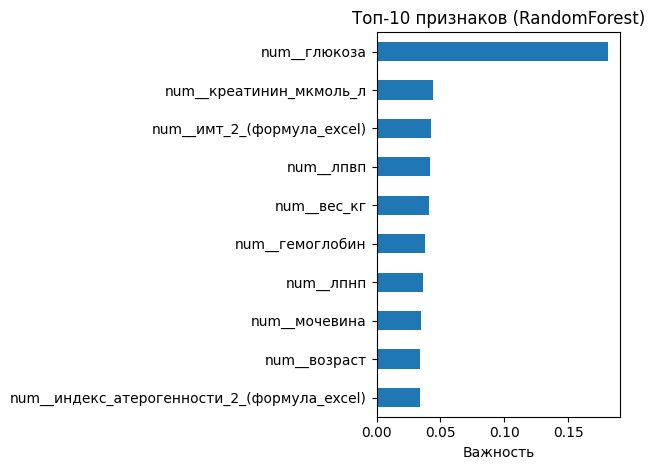

In [76]:
best_pipe = search_rf.best_estimator_

sfm = best_pipe.named_steps['feature_selection']
rf_in_sfm = sfm.estimator_

feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()

selected_mask = sfm.get_support()
selected_features = feature_names[selected_mask]

importances = rf_in_sfm.feature_importances_
feat_imp = pd.Series(importances[selected_mask], index=selected_features)

feat_imp.nlargest(10).plot(kind='barh')
plt.xlabel('Важность')
plt.title('Топ-10 признаков (RandomForest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## SVC

Для модели SVC будем перебирать тип ядра, параметр регуляризации, коэффициент ядра, степень полинома для kernel='poly', а также метод масштабирования числовых признаков.

In [77]:
pipe_svc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('scaler', StandardScaler()),
    ('model', SVC(probability=True, random_state=RANDOM_STATE, ))
])

param_dist_svc = {
    'model__C': [0.5,1,2,3,4,5,6,7,8,9,10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__degree': randint(2, 5),
    'model__gamma': ['scale', 'auto'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

search_svc = RandomizedSearchCV(
    pipe_svc,
    param_distributions=param_dist_svc,
    scoring='f1_macro',
    cv=3,
    n_iter=50,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

search_svc.fit(X_train, y_train)

print('Оптимальные параметры SVC:', search_svc.best_params_)
print('Лучшее значение F1 macro (CV):', round(search_svc.best_score_, 5))

models.append('svc')
metrics.append(search_svc.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Оптимальные параметры SVC: {'model__C': 9, 'model__degree': 3, 'model__gamma': 'scale', 'model__kernel': 'poly', 'preprocessor__num': 'passthrough'}
Лучшее значение F1 macro (CV): 0.68363


Метрика на тесте.

In [78]:
y_test_pred_svc = search_svc.best_estimator_.predict(X_test)

print(f"SVC F1 macro (test):  {round(f1_score(y_test, y_test_pred_svc, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_svc, average='macro'))

SVC F1 macro (test):  0.655


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Наиболее важные признаки лучшей модели SVC.

Модель SVC с полиноминальным ядром не дает доступа к коэффициентам для анализа признаков, поэтому будет использован метод Permutation Importance (перестановочная важность).

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


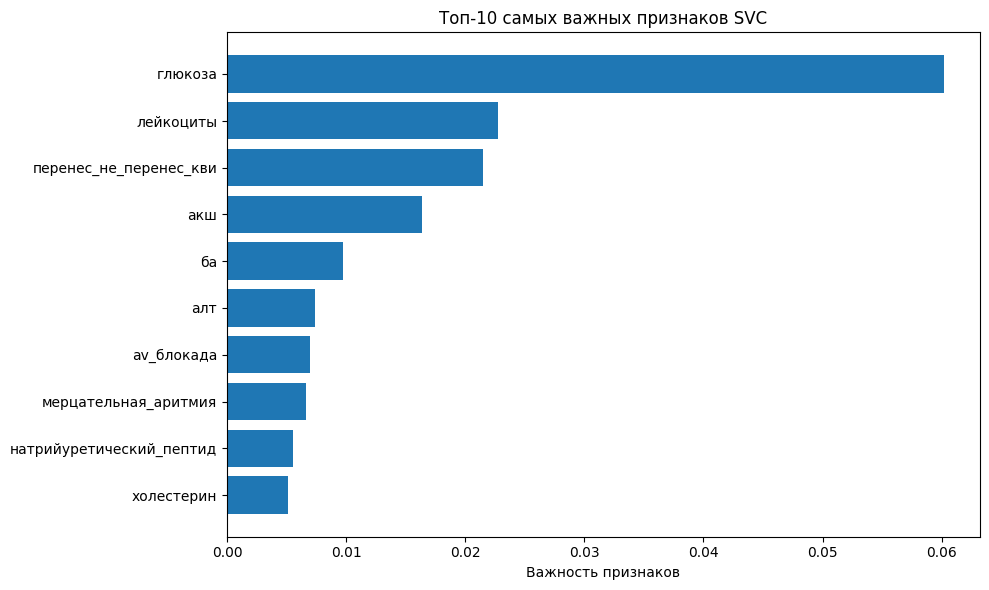

In [79]:
features_svc = permutation_importance(
    search_svc.best_estimator_,
    X_test,
    y_test,
    scoring='f1_macro',
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


sorted_features = features_svc.importances_mean.argsort()[-10:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), features_svc.importances_mean[sorted_features], align='center')
plt.yticks(range(len(sorted_features)), X_test.columns[sorted_features])
plt.title('Топ-10 самых важных признаков SVC')
plt.xlabel('Важность признаков')
plt.tight_layout()
plt.show()

## XGBClassifier

Для модели градиентного бустинга XGBClassifier будем перебирать:
*   параметры бустинга: число деревьев, скорость обучения,
*   параметры дерева: максимальная глубина; доля строк, используемых для обучения каждого дерева; доля признаков, используемых для каждого дерева; минимальное уменьшение loss (потерь), необходимое для дальнейшего разделения узла в дереве.



In [80]:
pipe_xgb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('scaler', 'passthrough'),
    ('model', XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE))
])

param_dist_xgb = {
    'model__n_estimators': randint(50, 300),
    'model__max_depth': randint(3, 16),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__gamma': uniform(0, 5),

}

search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist_xgb,
    scoring='f1_macro',
    cv=3,
    n_iter=50,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

search_xgb.fit(X_train, y_train)

print('Оптимальные параметры XGBoost:', search_xgb.best_params_)
print('Лучшее значение F1 macro (CV):', round(search_xgb.best_score_, 5))

models.append('xgb')
metrics.append(search_xgb.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Оптимальные параметры XGBoost: {'model__colsample_bytree': np.float64(0.949916356306367), 'model__gamma': np.float64(0.4097659633463402), 'model__learning_rate': np.float64(0.24833104901525693), 'model__max_depth': 12, 'model__n_estimators': 123, 'model__subsample': np.float64(0.7840197593191048)}
Лучшее значение F1 macro (CV): 0.73754


Метрика на тесте.

In [81]:
y_test_pred_xgb = search_xgb.best_estimator_.predict(X_test)

print(f"XGBClassifier F1 macro (test):  {round(f1_score(y_test, y_test_pred_xgb, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_xgb, average='macro'))

XGBClassifier F1 macro (test):  0.68036


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Наиболее важные признаки для лучшей модели XGBClassifier.

In [82]:
top_features_model_specific(search_xgb.best_estimator_, top_n=10, prefix_to_strip=5)

,Признак,Важность
37,глюкоза,0.094835
13,аг_степень,0.056524
0,перенес_не_перенес_кви_2,0.045577
25,имт_2_(формула_excel),0.039435
34,лпнп,0.038935
33,холестерин,0.037987
26,эритроциты,0.037235
22,возраст,0.033921
43,скф_ckd_epi_(расчет_по_общей_формуле),0.032748
30,лимфоциты_абс_(расчет_по_формуле),0.031752


## KNeighborsClassifier

Для модели k-соседей будем перебирать число соседей, метод масштабирования численных признаков и схемы взвешивания объектов в наборе (равномерные веса или пропорциональные обратной величине расстояния от точки запроса).

Эта модель не имеет встроенной оценки важности признаков, поэтому для нее используем метод SelectKBest, который выбирает лучшие признаки на основе статистических тестов. Число важных признаков также перебираем как гиперпараметр.

In [83]:
pipe_kneighbors = Pipeline([
    ('preprocessor', data_preprocessor),
    ('select', SelectKBest(mutual_info_classif)),
    ('model', KNeighborsClassifier())
])

param_grid_kneighbors = {
    'model__n_neighbors':  range(1, 20),
    'model__weights': ['uniform', 'distance'],
    'select__k': range(1, 20),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

search_kneighbors = RandomizedSearchCV(
    pipe_kneighbors,
    param_distributions=param_grid_kneighbors,
    scoring='f1_macro',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search_kneighbors.fit(X_train, y_train)

print('Оптимальные параметры модели KNeighborsClassifier', search_kneighbors.best_params_)
print ('Метрика лучшей модели F1 macro (CV):', round(search_kneighbors.best_score_, 5))

models.append('knn')
metrics.append(search_kneighbors.best_score_)

Оптимальные параметры модели KNeighborsClassifier {'select__k': 1, 'preprocessor__num': StandardScaler(), 'model__weights': 'uniform', 'model__n_neighbors': 6}
Метрика лучшей модели F1 macro (CV): 0.70699


Метрика на тесте.

In [84]:
y_test_pred_kneighbors = search_kneighbors.best_estimator_.predict(X_test)

print(f"kneighbors F1 macro (test):  {round(f1_score(y_test, y_test_pred_kneighbors, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_logreg, average='macro'))

kneighbors F1 macro (test):  0.71111


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Из подобранных гиперпараметров видно, что селектор отобрал всего один признак как наиболее важный, выведем его название.

In [85]:
from sklearn.feature_selection import SelectKBest, f_regression
best_model = search_kneighbors.best_estimator_

knk = best_model.named_steps['select']

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

selected_mask = knk.get_support()
selected_features = feature_names[selected_mask]
print("Наиболее важный признак ", selected_features)

Наиболее важный признак  ['num__глюкоза']


Таким образом, для модели kneighbors наиболее важным признаком стал уровень глюкозы в крови.

## CatBoostClassifier

Модель CatBoost имеет встроенный кодировщик категориальных признаков, но данные в таких столбцах должны быть однородные.

У нас выявились столбцы со смешанным содержимым, которые катбуст не может обработать как категориальные признаки:

BPB голеней [0, 1, 3, 2, '2-3', 4]

Блокада НП Гисса [1, 0, 2, '1-2']

AV- блокада [0, 1, '2-3', 2, 3, '1-2', '3']

ХБП (исходн) [0, 'с3а', 'с2', 'с1', 'с3', ..., 'с3а-с3б', 'с3б', '2а', '2са1', 'с2-с3'].

Предлагается подойти к столбцам дифференцированно.

ВРВ - варикозное расширение вен. Стадию 2-3 можно заменить на стадию 3 без ущерба для столбца, тем более что в таблице всего 2 таких значения.

Блокада НП Гисса по сведениям из интернета бывает однопучковой, двухпучковой и трёхпучковой. Непонятно значение "1-2", комментарии в соседнем столбце говорят, что оно может означать "1 и 2". И все-таки числовые значения тут имеют порядковый смысл: чем больше пучков закупорено, тем хуже кровоснабжение сердца. Поэтому можно попробовать заменить "1-2" на 1.5, хотя это не имеет физического смысла.

AV- блокада имеет стадии 1, 2, 3 и полную, чем больше - тем хуже. Здесь то же самое, переходные категории попробуем заменить на среднее значение, т.е. "2-3" на 2.5, хотя это не имеет физического смысла.

ХБП - хроническая болезнь почек имеет стадии не численные, а в текстовом формате. Чтобы 0 не портил строковые значения, можно заменить его "abs".

Заменяем значения столбцов:

In [86]:
def convert_value(x):
    if isinstance(x, str) and '-' in x:
        a, b = map(float, x.split('-'))
        return (a + b) / 2  # Среднее значение диапазона
    return float(x)

X_train['блокада_нп_гисса'] = X_train['блокада_нп_гисса'].apply(convert_value)
X_train['av_блокада'] = X_train['av_блокада'].apply(convert_value)
X_train['врв_голеней'] = X_train['врв_голеней'].replace('2-3', 3).astype(int)
X_train['хбп_(исходн)'] = X_train['хбп_(исходн)'].replace(0, 'abs').astype(str)

X_test['блокада_нп_гисса'] = X_test['блокада_нп_гисса'].apply(convert_value)
X_test['av_блокада'] = X_test['av_блокада'].apply(convert_value)
X_test['врв_голеней'] = X_test['врв_голеней'].replace('2-3', 3).astype(int)
X_test['хбп_(исходн)'] = X_test['хбп_(исходн)'].replace(0, 'abs').astype(str)

/tmp/ipython-input-86-2459436539.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train['врв_голеней'] = X_train['врв_голеней'].replace('2-3', 3).astype(int)
/tmp/ipython-input-86-2459436539.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X_train['врв_голеней'] = X_train['врв_голеней'].replace('2-3', 3).astype(int)
/tmp/ipython-input-86-2459436539.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categ

Проверяем корректность замены.

In [87]:
for i in ord_columns:
  print(i,X_train[i].unique())

врв_голеней [1 0 2 3 4]
блокада_нп_гисса [0.0, 1.0, 2.0, 1.5]
Categories (4, float64): [0.0, 1.0, 2.0, 1.5]
av_блокада [0.  1.  2.5 2.  3.  1.5]
хбп_(исходн) ['abs' 'с1' 'с3а' 'с3б' 'с2' 'с3' '2са1' 'с2-с3' 'с3а-с3б' 'с4' '2а']
аг_степень [1, 3, 0, 2, 4]
Categories (5, int64): [0, 1, 2, 3, 4]
аг_риск [4, 0, 3, 2]
Categories (4, int64): [0, 2, 3, 4]
хсн_стадии [2, 3, 1, 4]
Categories (4, int64): [1, 2, 3, 4]
хсн_фк [0, 3, 2, 4, 1]
Categories (5, int64): [0, 1, 2, 3, 4]
ибс_стенокардия [2, 0, 1, 3, 4]
Categories (5, int64): [0, 1, 2, 3, 4]
хбп_(расчет_по_скф) [1, 5, 2, 3, 4]
Categories (5, int64): [1, 2, 3, 4, 5]
мерцательная_аритмия [0, 1, 2]
Categories (3, int64): [0, 1, 2]
ба [0, 1]
Categories (3, int64): [0, 1, 2]
хобл [0, 1, 2]
Categories (3, int64): [0, 1, 2]


Теперь фиксируем cat_features - категориальные столбцы для встроенного кодировщика.

In [88]:
cat_features = ord_columns + ohe_columns
X_train[cat_features] = X_train[cat_features].astype(str).astype('category')
X_test[cat_features] = X_test[cat_features].astype(str).astype('category')

Для модели CatBoostClassifier будем перебирать всего два параметра: максимальную глубину дерева и скорость обучения, поскольку эта модель обучается очень долго.

In [89]:
params = {
    'depth': [4, 6],
    'learning_rate': [0.01,0.05]
}
classifier = CatBoostClassifier(
    iterations=500,
    random_state=RANDOM_STATE,
    thread_count=-1,
    early_stopping_rounds=20
    )

search_catboost = RandomizedSearchCV(
    classifier,
    params,
    scoring='f1_macro',
    n_jobs=-1,
    cv=3,
    random_state=RANDOM_STATE
)
start = time.perf_counter()

search_catboost.fit(X_train, y_train, cat_features=cat_features, verbose=False)

end=time.perf_counter()
elapsed =end - start
print(f"Затрачено времени: {elapsed} сек")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Затрачено времени: 39.569929629 сек


In [90]:
print('Оптимальные параметры модели catboost', search_catboost.best_params_)
print ('Метрика лучшей модели F1 macro (CV):', round(search_catboost.best_score_, 5))

models.append('catboost')
metrics.append(search_catboost.best_score_)

Оптимальные параметры модели catboost {'learning_rate': 0.01, 'depth': 6}
Метрика лучшей модели F1 macro (CV): 0.72632


Метрика на тесте.

In [91]:
y_test_pred_catboost = search_catboost.best_estimator_.predict(X_test)

print(f"catboost F1 macro (test):  {round(f1_score(y_test, y_test_pred_catboost, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_catboost, average='macro'))

catboost F1 macro (test):  0.70369


Анализ важности признаков.

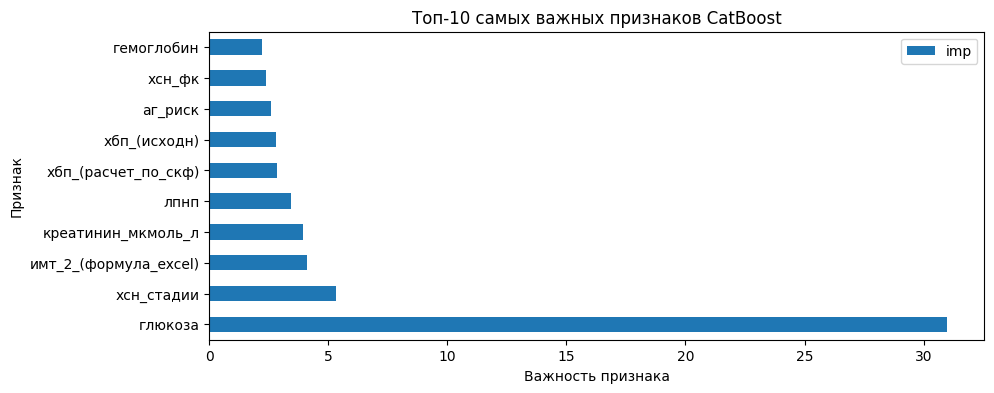

In [92]:
importances = search_catboost.best_estimator_.feature_importances_

# создаем таблицу важности признаков
table = pd.DataFrame({
    'imp': importances,
    'columns': X_train.columns
})

sorted_df = table.sort_values(by='imp', ascending=False).head(10)
sorted_df.plot(x='columns', y='imp', kind='barh', figsize=(10, 4))

plt.title('Топ-10 самых важных признаков CatBoost')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()

## LGBMClassifier

Указываем категориальные признаки, как в катбусте:

In [93]:
cat_features = ord_columns + ohe_columns

Для модели LGBMClassifier будем перебирать максимальную глубину дерева, скорость обучения и число деревьев, которые будут построены в процессе обучения модели.

In [94]:
params = {
    'max_depth': range(4, 6, 8),
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 500],
 }

classifier=LGBMClassifier(
    objective='binary',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose = -1)

search_lgbm = RandomizedSearchCV(
    classifier,
    params,
    scoring='f1_macro',
    n_jobs=-1,
    cv=3,
    n_iter=100,
    error_score='raise',
    random_state=RANDOM_STATE
)
start = time.perf_counter()

search_lgbm.fit(X_train, y_train, categorical_feature=cat_features)

end=time.perf_counter()
elapsed =end - start
print(f"Затрачено времени: {elapsed} сек")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Затрачено времени: 9.364752568000029 сек


In [95]:
print('Оптимальные параметры модели lgbmClassifier', search_lgbm.best_params_)
print ('Метрика лучшей модели F1 macro (CV):', round(search_lgbm.best_score_, 5))

models.append('lgbm')
metrics.append(search_lgbm.best_score_)

Оптимальные параметры модели lgbmClassifier {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05}
Метрика лучшей модели F1 macro (CV): 0.7235


Метрика на тесте.

In [96]:
y_test_pred_lgbm = search_lgbm.best_estimator_.predict(X_test)

print(f"lgbm F1 macro (test):  {round(f1_score(y_test, y_test_pred_lgbm, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_lgbm, average='macro'))

lgbm F1 macro (test):  0.65774


Анализ важности признаков.

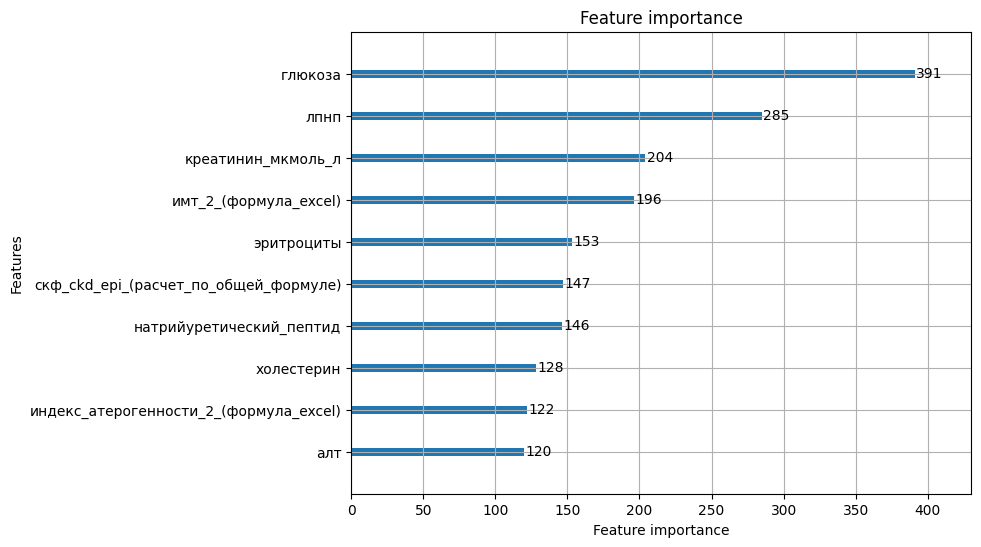

In [97]:
# встроенная функция для построения графиков важности признаков
lgb.plot_importance(search_lgbm.best_estimator_, max_num_features=10, figsize=(8,6));

## SGDClassifier

Для модели стохастического градиентного спуска SGD будем перебирать функцию потерь, тип и силу регуляризации, максимальное число итераций и метод масштабирования числовых признаков.

In [98]:
pipe_sgd = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', SGDClassifier(random_state=RANDOM_STATE))
])

param_dist_sgd = {
    'model__loss': ['log_loss', 'hinge'],
    'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1.0],
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__max_iter': [1000, 2000],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

search_sgd = RandomizedSearchCV(
    pipe_sgd,
    param_distributions=param_dist_sgd,
    scoring='f1_macro',
    cv=3,
    random_state=RANDOM_STATE,
    n_iter=30,
    n_jobs=-1,
    verbose=2
)

search_sgd.fit(X_train, y_train)

print('Оптимальные параметры SGDClassifier:', search_sgd.best_params_)
print('F1 macro (CV):', round(search_sgd.best_score_, 5))

models.append('sgd')
metrics.append(search_sgd.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Оптимальные параметры SGDClassifier: {'preprocessor__num': StandardScaler(), 'model__penalty': 'elasticnet', 'model__max_iter': 1000, 'model__loss': 'log_loss', 'model__alpha': 0.1}
F1 macro (CV): 0.73975


Метрика на тесте.

In [99]:
y_test_pred_sgd = search_sgd.best_estimator_.predict(X_test)

print(f"sgd F1 macro (test):  {round(f1_score(y_test, y_test_pred_sgd, average='macro'),5)}")
metrics_test.append(f1_score(y_test, y_test_pred_sgd, average='macro'))

sgd F1 macro (test):  0.68805


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Анализ важности признаков.

In [100]:
top_features_coef(search_sgd.best_estimator_, top_n=10, prefix_to_strip=5)

,Признак,Коэффициент
37,глюкоза,0.730020
14,аг_риск,0.169270
25,имт_2_(формула_excel),0.150928
22,возраст,0.144380
28,лейкоциты,0.113376
34,лпнп,0.099230
32,соэ,0.094947
38,алт,0.077775
27,гемоглобин,0.073621
43,скф_ckd_epi_(расчет_по_общей_формуле),0.071970


**Вывод**

На данном этапе

- Обучены и настроены 8 моделей с помощью `Pipeline` и `RandomizedSearchCV`:
  - **LogisticRegression**
  - **DecisionTreeClassifier**
  - **RandomForestClassifier**
  - **SVC**
  - **XGBoost**
  - **KNeighborsClassifier**
  - **CatBoostClassifier**
  - **LGBMClassifier**
  - **SGDClassifier**

- Для каждой модели выполнен подбор гиперпараметров с кросс-валидацией по метрике `F1 macro`.

- Проведена интерпретация моделей через написанные ранее функции

- Проведена ручная предобработка смешанных категориальных значений для корректной работы CatBoost и LightGBM.

- Все метрики `F1 macro` сохранены на кросс-валидации и тестовой выборке для последующего сравнения.


# Сравнение моделей

Выведем итоговую таблицу с метриками для каждой модели.

In [101]:
compare = pd.DataFrame({
    'model': models,
    'metrics_cv': metrics,
    'metrics_test': metrics_test,
})

display(compare.sort_values('metrics_test', ascending=False))

,model,metrics_cv,metrics_test
2,random_forest,0.737309,0.717760
6,catboost,0.726316,0.703687
8,sgd,0.739752,0.688050
4,xgb,0.737541,0.680359
7,lgbm,0.723497,0.657738
3,svc,0.683628,0.655000
0,logreg,0.719875,0.649931
5,knn,0.706993,0.649931
1,decision_tree,0.712588,0.634146


- **Лучшее качество на тестовой выборке** показала модель  **RandomForestClassifier (F1 = 0.72)**, несмотря на не самое высокое значение на кросс-валидации (незначительно уступает модели SGD). Важно отметить, что для данной модели наблюдается минимальная разница между метриками на CV и тестовой выборке, что говорит о стабильности модели.
- **CatBoostClassifier** незначительно уступает по качеству модели RandomForestClassifier.
- **Самую высокую метрику на CV** показала модель **SGD**, но на тесте метрика упала на 0.05, что свидетельствует о переобучении.
- Модель **SVC** имеет низкую метрику на CV и незначительное падение метрики на тестовой выборке.
- Остальные модели переобучились


Протестируем наши модели против DummyClassifier - "фиктивного" классификатора, который делает предсказания по простым правилам без реального обучения. Тогда мы сможем оценить, насколько наши  модели лучше случайного угадывания. В качестве стратегии угадывания DummyClassifier	возьмем "stratified", для того чтобы сохранить  распределение классов, как в обучающих данных.


In [102]:
from sklearn.dummy import DummyClassifier

# создание и обучение модели DummyClassifier
dummy_model = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

print(f"dummy_model F1 macro (test):  {round(f1_score(y_test, dummy_model_preds, average='macro'),5)}")

dummy_model F1 macro (test):  0.5621


Как видим, все наши модели по метрике  F1 macro примерно на 0,2 превосходят модель случайного угадывания, что говорит об их адекватности.

# Выводы по проделанной работе

- 🔍 **Первичный анализ:** очищены названия признаков, удалены дубликаты и строки с критически важными пропусками (потери ~7%).

- 🧹 **Обработка пропусков:** непрерывные признаки заполнены медианой/модой, категориальные — нулями или логическим соответствием.

- 🧾 **Обработка признаков:** пересчитаны производные показатели (ИМТ, индекс атерогенности), упрощены категории, удалены некорректные признаки.

- 📊 **Корреляционный анализ:** удалены признаки, создающие утечку данных (например, лекарства), и дублирующие признаки с высокой корреляцией.

- 🛠️ **Подготовка данных:** реализован универсальный препроцессор с масштабированием, OneHot и Ordinal-кодированием, подготовлены функции для анализа важности признаков.

- 🤖 **Обучение моделей:** обучены 9 моделей с подбором гиперпараметров и интерпретацией важности признаков.

- 📈 **Сравнение моделей:** наилучший результат на тесте показала модель  **RandomForestClassifier (F1 = 0.72)**.

- **Анализ важности признаков** по всем моделям показал, что главным признаком для предсказания является уровень глюкозы в крови, все остальные признаки вносят гораздо меньший вклад в предсказания моделей.

🎯 **Итог:** получена интерпретируемая и сбалансированная модель для предсказания диабета. Рекомендуемый финальный кандидат: `RandomForestClassifier`.